<a href="https://colab.research.google.com/github/foxtrotmike/AS/blob/master/BinAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

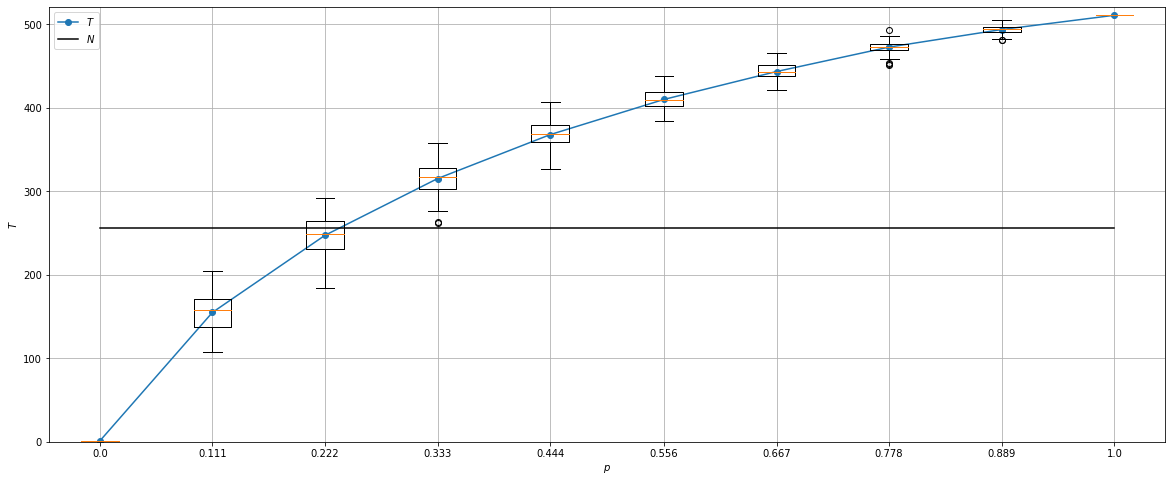

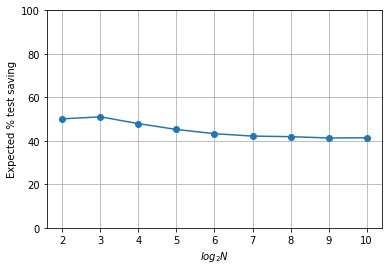

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  7 12:41:22 2020

@author: fayya
"""
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
def TestBag(b):    
    global T
    global S
    global L
    y = np.any(L[b]) #lab test over samples in B
    T+=1
    if y==0:
        S[b]=0
        return 0
    else:
        return 1
    
def SplitAndTest(b):    
    global S
    global L
    global T
    if len(b)==1:        
        S[b[0]]=TestBag(b)
    else:
        s = int(np.floor(len(b)/2))
        bleft,bright=b[:s],b[s:]
        #print(bleft,bright)
        if TestBag(bleft)==0: #left bag is negative
            if len(bright)==1:
                S[bright[0]]=1
            else:
                SplitAndTest(bright)
        else: #left bag is positive
            if len(bleft)>1:
                SplitAndTest(bleft)
            else:
                S[bleft[0]]=1
            if TestBag(bright)==1:
                if len(bright)>1:
                    SplitAndTest(bright)
                else:
                    S[bright[0]]=1
                
def simulate(N,p,n):
    global L
    global S
    global T
    L = 1.0*(np.random.rand(N)<p)
    if n>=0:
        X = L+0    
        X[L==1]+=n*np.random.randn(np.sum(L==1))
        X[L==0]+=n*np.random.randn(np.sum(L==0))
    else:
        X = np.random.rand(N)    
    X = (X-np.min(X))/(np.max(X)-np.min(X))
    idx = list(range(len(L)))
    idx = np.argsort(X)    
    X,L = X[idx], L[idx]
    T = 0
    S = -1*np.ones(N) #no decisions available
    B = np.arange(N)    
    if TestBag(B):
        SplitAndTest(B)
    assert np.all(S==L)
    try:
        auc = roc_auc_score(L,X)
    except ValueError as e:
        auc = 1.0
    
    return T, auc

if __name__=='__main__':
    ntrials = 100
    N = int(2**8)
    P = np.linspace(0,1.0,10)#[-1:]
    Z = []
    n = 3.0 #noise factor
    A = []
    for p in tqdm(P):   
        TT = []
        for _ in range(ntrials):
            T,a = simulate(N,p,n)  
            A.append(a)
            TT.append(T)
        Z.append(TT)
        #print(np.mean(TT))
    
    Z = np.array(Z).T   
    #%%    
    xx = [round(xx,3) for xx in P]
    y = Z.mean(axis=0)    
    fig = plt.figure(figsize=(20, 8))    
    plt.plot(xx,y,'o-')
    fp = 2*(N-1)*(1-2**(-4.5*P))+1
    
    
    #plt.plot(xx,fp)
    plt.plot(xx,[N]*len(xx),'k')
    #plt.legend(['$T$','$t(p,N)=2(N-1)(1-2^{-4.5p})+1$','$N$'])
    plt.legend(['$T$','$N$'])
    locs, labels = plt.xticks() 
    plt.boxplot(Z, positions=xx, widths = (xx[2]-xx[1])/3,notch=False)
    plt.xticks(xx)
    plt.axis('tight')
    plt.grid()#    
    plt.xlim(min(xx)-0.05, max(xx)+0.05)
    plt.ylim(0, np.max(y)+10)
    plt.xlabel('$p$')
    plt.ylabel('$T$')    
    plt.show()
#%%
    
    NN = 2**np.arange(2,11)
    p = 0.1
    n = n
    Y = []
    trials = 1000
    for N in tqdm(NN):
      tt = []
      for _ in range(trials):
        T,_ = simulate(N,p,n)
        tt.append(T)
      Y.append(np.mean(tt))
    plt.figure()
    plt.plot(np.log2(NN),100*(NN-Y)/NN,'o-');plt.ylim(0,100);plt.grid();plt.xlabel("$log_2 N$");plt.ylabel("Expected % test saving");
    #print(out)
    #CC,L,B = out
    #print(len(L)-np.min(np.nonzero(L)[0]))
    #print(np.mean(len(L)-np.nonzero(L)[0])/len(L))
    #plt.figure()
    #NN = 2**np.arange(1,10); y = [(-1/6)*np.log2(1-N/(2*(N-1))) for N in NN]; plt.plot(np.log2(NN),y,'o-');plt.ylim(0,0.5);plt.grid();plt.xlabel("$log_2 N$");plt.ylabel("$p_{t(N,p)=N}$");
    